## 1. [Libraries and settings](#1-bullet)

In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")




In [254]:
df = pd.read_csv('C:/CD_C/20231/Project 1/Project/Data/MBB.csv', sep='\t', index_col=0)

In [255]:
df.head()

,Open,High,Low,Close,Volume,TradingDate,Code
0,3068.0,3068.0,2920.0,2920.0,2719290,2011-11-01,MBB
1,2878.0,2920.0,2793.0,2793.0,1255220,2011-11-02,MBB
2,2751.0,2793.0,2666.0,2772.0,1193910,2011-11-03,MBB
3,2793.0,2793.0,2729.0,2729.0,483860,2011-11-04,MBB
4,2729.0,2729.0,2602.0,2602.0,1158750,2011-11-07,MBB


In [256]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2850 entries, 0 to 2849
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Open         2850 non-null   float64
 1   High         2850 non-null   float64
 2   Low          2850 non-null   float64
 3   Close        2850 non-null   float64
 4   Volume       2850 non-null   int64  
 5   TradingDate  2850 non-null   object 
 6   Code         2850 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 178.1+ KB


In [257]:
df.describe()

,Open,High,Low,Close,Volume
count,2850.000000,2850.000000,2850.000000,2850.000000,2.850000e+03
mean,9670.182456,9791.270877,9549.658246,9664.632281,5.145129e+06
std,6724.320190,6819.385456,6618.501311,6712.067485,6.264514e+06
min,2412.000000,2498.000000,2412.000000,2452.000000,0.000000e+00
25%,4261.000000,4294.000000,4229.000000,4259.500000,7.848725e+05
50%,8158.000000,8302.000000,8076.500000,8226.000000,2.944755e+06
75%,11915.250000,12076.750000,11755.000000,11936.250000,6.925602e+06
max,28832.000000,29082.000000,28457.000000,28666.000000,5.162240e+07


In [258]:
df['TradingDate'] = pd.to_datetime(df['TradingDate'], format='%Y-%m-%d')

In [259]:
df = df.dropna()

## 2. [Visualization](#2-bullet)

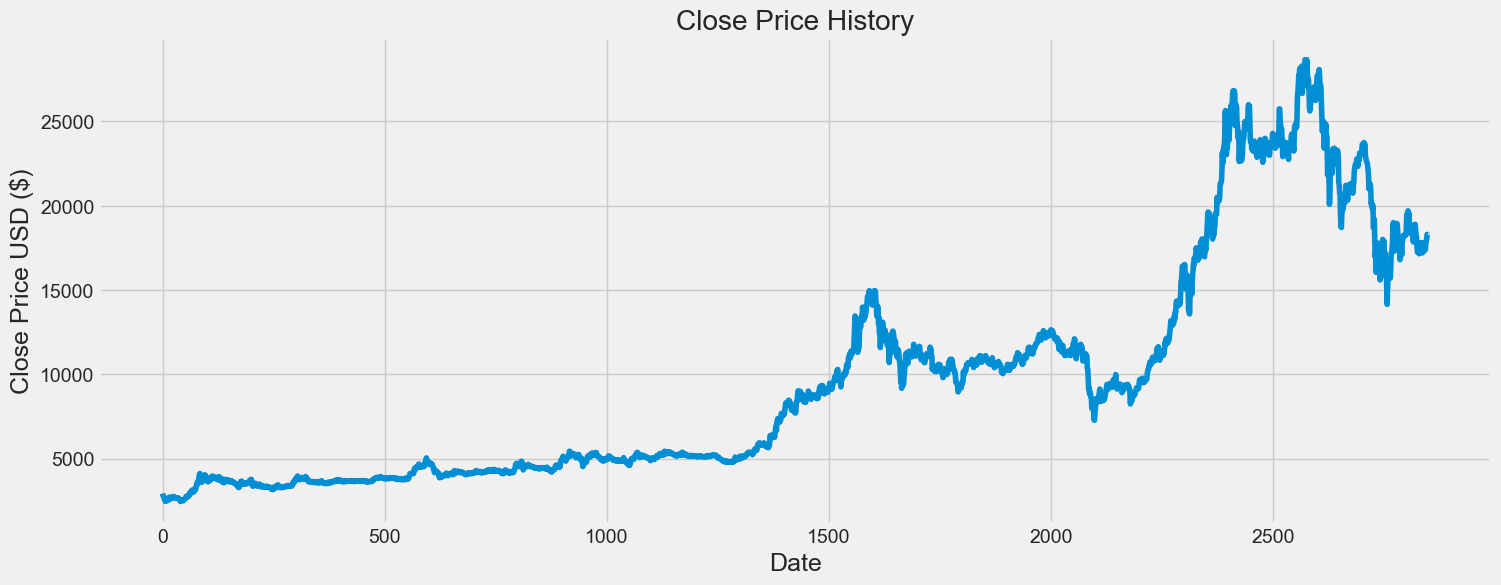

In [260]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

## 3. [Data Manipulation](#3-bullet)

In [261]:
# Create a new dataframe
data = df.filter(['Close', 'Volume'])
# Convert the dataframe to a numpy array
dataset = data.values
dataset

array([[2.9200000e+03, 2.7192900e+06],
       [2.7930000e+03, 1.2552200e+06],
       [2.7720000e+03, 1.1939100e+06],
       ...,
       [1.8300000e+04, 1.0444796e+07],
       [1.8250000e+04, 8.9824720e+06],
       [1.8250000e+04, 1.0542940e+07]])

In [262]:
dataset.shape

(2850, 2)

In [263]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[-1.00502802, -0.38730302],
       [-1.02395248, -0.62105251],
       [-1.02708172, -0.6308411 ],
       ...,
       [ 1.28676941,  0.84613058],
       [ 1.27931883,  0.61265985],
       [ 1.27931883,  0.86179999]])

## 4. [Create Dataset](#4-bullet)

In [264]:
time_step = 30 # học dữ liệu 30 ngày trước để dự đoán cho ngày tiếp theo
def create_dataset(dataset, time_step=30):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step):
        dataX.append(dataset[i:(i+time_step), :].flatten())
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [265]:
x_for_train, y_for_train = create_dataset(scaled_data, time_step)
x_for_train.shape

(2820, 60)

In [266]:
training_size=int(len(dataset)*0.8) # dữ liệu để train chiếm 80%, dữ liệu để test chiếm 20%
test_size=len(dataset)-training_size
train_data,test_data=scaled_data[0:training_size],scaled_data[training_size:len(dataset)]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (2280, 2)
test_data:  (570, 2)


In [267]:
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test", y_test.shape)

x_train:  (2250, 60)
y_train:  (2250,)
x_test:  (540, 60)
y_test (540,)


## 5. [Hyperparameter Tuning](#5-bullet)

In [268]:
from sklearn.model_selection import GridSearchCV


# Tạo một mô hình SVR
lasso = Lasso()

# Định nghĩa không gian tham số để tìm kiếm
param_grid = {
    'alpha' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    'max_iter': [500, 1000, 1500],
    'tol': [1e-4, 1e-3, 1e-2],
    'selection': ['cyclic', 'random']
}

grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)

grid_search.fit(x_train, y_train)

# In ra các tham số tốt nhất
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best score achieved: {grid_search.best_score_}")

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END alpha=1e-05, max_iter=500, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=500, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=500, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=500, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=500, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=500, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=500, selection=cyclic, tol=0.001; total time=   0.0s


c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.483e-01, tolerance: 3.903e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.895e-01, tolerance: 4.466e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.158e-01, toleranc

[CV] END alpha=1e-05, max_iter=500, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=500, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=500, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=500, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=1e-05, max_iter=500, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=1e-05, max_iter=500, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=1e-05, max_iter=500, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=1e-05, max_iter=500, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=1e-05, max_iter=500, selection=random, tol=0.0001; total time=   0.0s


c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.158e-01, tolerance: 4.921e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.395e-01, tolerance: 3.306e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.086e-01, toleranc

[CV] END alpha=1e-05, max_iter=500, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=500, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=500, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=500, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=500, selection=random, tol=0.001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=500, selection=random, tol=0.001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=500, selection=random, tol=0.001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=500, selection=random, tol=0.001; total time=   0.0s


c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.030e-01, tolerance: 3.291e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.136e-01, tolerance: 3.903e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.257e-01, toleranc

[CV] END alpha=1e-05, max_iter=500, selection=random, tol=0.001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=500, selection=random, tol=0.01; total time=   0.0s
[CV] END alpha=1e-05, max_iter=500, selection=random, tol=0.01; total time=   0.0s
[CV] END alpha=1e-05, max_iter=500, selection=random, tol=0.01; total time=   0.0s
[CV] END alpha=1e-05, max_iter=500, selection=random, tol=0.01; total time=   0.0s
[CV] END alpha=1e-05, max_iter=500, selection=random, tol=0.01; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1000, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1000, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1000, selection=cyclic, tol=0.0001; total time=   0.0s


c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.753e-01, tolerance: 4.466e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.924e-01, tolerance: 4.921e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.569e-01, toleranc

[CV] END alpha=1e-05, max_iter=1000, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1000, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1000, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1000, selection=cyclic, tol=0.001; total time=   0.0s


c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.257e-01, tolerance: 3.903e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.753e-01, tolerance: 4.466e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.924e-01, toleranc

[CV] END alpha=1e-05, max_iter=1000, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1000, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1000, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1000, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1000, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1000, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1000, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1000, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1000, selection=random, tol=0.0001; total time=   0.0s


c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.305e-01, tolerance: 3.291e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.132e-01, tolerance: 3.903e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.962e-01, toleranc

[CV] END alpha=1e-05, max_iter=1000, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1000, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1000, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1000, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1000, selection=random, tol=0.001; total time=   0.0s


c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.328e-01, tolerance: 3.306e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.765e-01, tolerance: 3.291e-02
  model = cd_fast.enet_coordinate_descent(


[CV] END alpha=1e-05, max_iter=1000, selection=random, tol=0.001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1000, selection=random, tol=0.001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1000, selection=random, tol=0.001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1000, selection=random, tol=0.001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1000, selection=random, tol=0.01; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1000, selection=random, tol=0.01; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1000, selection=random, tol=0.01; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1000, selection=random, tol=0.01; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1000, selection=random, tol=0.01; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1500, selection=cyclic, tol=0.0001; total time=   0.0s


c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.957e-01, tolerance: 3.903e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.616e-01, tolerance: 4.466e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.838e-01, toleranc

[CV] END alpha=1e-05, max_iter=1500, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1500, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1500, selection=cyclic, tol=0.0001; total time=   0.0s


c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.791e-01, tolerance: 3.306e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.290e-01, tolerance: 3.291e-02
  model = cd_fast.enet_coordinate_descent(


[CV] END alpha=1e-05, max_iter=1500, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1500, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1500, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1500, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1500, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1500, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1500, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1500, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1500, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1500, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1500, selection=cyclic, tol=0.01; total time=   0.0s


c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.602e-01, tolerance: 3.903e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.263e-01, tolerance: 4.466e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.615e-01, toleranc

[CV] END alpha=1e-05, max_iter=1500, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1500, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1500, selection=random, tol=0.0001; total time=   0.0s


c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.132e-01, tolerance: 3.306e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.507e-02, tolerance: 3.291e-02
  model = cd_fast.enet_coordinate_descent(


[CV] END alpha=1e-05, max_iter=1500, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1500, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1500, selection=random, tol=0.001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1500, selection=random, tol=0.001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1500, selection=random, tol=0.001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1500, selection=random, tol=0.001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1500, selection=random, tol=0.001; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1500, selection=random, tol=0.01; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1500, selection=random, tol=0.01; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1500, selection=random, tol=0.01; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1500, selection=random, tol=0.01; total time=   0.0s
[CV] END alpha=1e-05, max_iter=1500, selection=random, tol=0.01; to

c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.657e-01, tolerance: 3.903e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.663e-01, tolerance: 4.466e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.415e-01, toleranc

[CV] END alpha=0.0001, max_iter=500, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=500, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=500, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=500, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=500, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=500, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=0.0001, max_iter=500, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=0.0001, max_iter=500, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=0.0001, max_iter=500, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=0.0001, max_iter=500, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=0.0001, max_iter=500, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=500, selection=random, tol=0.0001; to

c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.364e-01, tolerance: 3.306e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.343e-01, tolerance: 3.291e-01
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.820e-02, toleranc

[CV] END alpha=0.0001, max_iter=500, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=500, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=500, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=500, selection=random, tol=0.001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=500, selection=random, tol=0.001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=500, selection=random, tol=0.001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=500, selection=random, tol=0.001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=500, selection=random, tol=0.001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=500, selection=random, tol=0.01; total time=   0.0s
[CV] END alpha=0.0001, max_iter=500, selection=random, tol=0.01; total time=   0.0s
[CV] END alpha=0.0001, max_iter=500, selection=random, tol=0.01; total time=   0.0s
[CV] END alpha=0.0001, max_iter=500, selection=random, tol=0.01; 

c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.875e-02, tolerance: 3.306e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.041e-02, tolerance: 3.291e-02
  model = cd_fast.enet_coordinate_descent(


[CV] END alpha=0.0001, max_iter=1000, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=1000, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=1000, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=1000, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=1000, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=0.0001, max_iter=1000, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=0.0001, max_iter=1000, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=0.0001, max_iter=1000, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=0.0001, max_iter=1000, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=0.0001, max_iter=1000, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=1000, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=1000, selection=random, t

c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.320e-02, tolerance: 3.306e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.145e-02, tolerance: 3.291e-02
  model = cd_fast.enet_coordinate_descent(


[CV] END alpha=0.0001, max_iter=1500, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=1500, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=1500, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=1500, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=1500, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=1500, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=1500, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=1500, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=1500, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=1500, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.0001, max_iter=1500, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=0.0001, max_iter=1500, selection=cy

c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.296e-02, tolerance: 3.903e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.125e-01, tolerance: 4.466e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.373e-01, toleranc

[CV] END alpha=0.001, max_iter=500, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.001, max_iter=500, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=0.001, max_iter=500, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=0.001, max_iter=500, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=0.001, max_iter=500, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=0.001, max_iter=500, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=0.001, max_iter=500, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=0.001, max_iter=500, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=0.001, max_iter=500, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=0.001, max_iter=500, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=0.001, max_iter=500, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=0.001, max_iter=500, selection=random, tol=0.001; total time=

c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.237e-02, tolerance: 3.903e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.572e-02, tolerance: 4.466e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.265e-02, toleranc

[CV] END alpha=0.001, max_iter=1000, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=0.001, max_iter=1000, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=0.001, max_iter=1000, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=0.001, max_iter=1000, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=0.001, max_iter=1000, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.001, max_iter=1000, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.001, max_iter=1000, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.001, max_iter=1000, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.001, max_iter=1000, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.001, max_iter=1000, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=0.001, max_iter=1000, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=0.001, max_iter=1000, selection=cyclic, tol=0.01

c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.342e-02, tolerance: 3.306e-02
  model = cd_fast.enet_coordinate_descent(


[CV] END alpha=0.001, max_iter=1000, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=0.001, max_iter=1000, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=0.001, max_iter=1000, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=0.001, max_iter=1000, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=0.001, max_iter=1000, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=0.001, max_iter=1000, selection=random, tol=0.001; total time=   0.0s
[CV] END alpha=0.001, max_iter=1000, selection=random, tol=0.001; total time=   0.0s
[CV] END alpha=0.001, max_iter=1000, selection=random, tol=0.001; total time=   0.0s
[CV] END alpha=0.001, max_iter=1000, selection=random, tol=0.001; total time=   0.0s
[CV] END alpha=0.001, max_iter=1000, selection=random, tol=0.001; total time=   0.0s
[CV] END alpha=0.001, max_iter=1000, selection=random, tol=0.01; total time=   0.0s
[CV] END alpha=0.001, max_iter=1000, selection=random, tol=0.

c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.118e-02, tolerance: 3.903e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.990e-02, tolerance: 4.466e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.238e-01, toleranc

[CV] END alpha=0.01, max_iter=500, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, max_iter=500, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, max_iter=500, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, max_iter=500, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, max_iter=500, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, max_iter=500, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=0.01, max_iter=500, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=0.01, max_iter=500, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=0.01, max_iter=500, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=0.01, max_iter=500, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=0.01, max_iter=500, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=0.01, max_iter=500, selection=random, tol=0.0001; total time=   0.0s
[CV] EN

c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.277e-02, tolerance: 3.291e-02
  model = cd_fast.enet_coordinate_descent(


[CV] END alpha=0.01, max_iter=1000, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=0.01, max_iter=1000, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=0.01, max_iter=1000, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=0.01, max_iter=1000, selection=cyclic, tol=0.0001; total time=   0.0s
[CV] END alpha=0.01, max_iter=1000, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, max_iter=1000, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, max_iter=1000, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, max_iter=1000, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, max_iter=1000, selection=cyclic, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, max_iter=1000, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=0.01, max_iter=1000, selection=cyclic, tol=0.01; total time=   0.0s
[CV] END alpha=0.01, max_iter=1000, selection=cyclic, tol=0.01; total time

c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.831e-02, tolerance: 4.466e-02
  model = cd_fast.enet_coordinate_descent(
c:\Users\ngovi\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.063e-01, tolerance: 3.306e-02
  model = cd_fast.enet_coordinate_descent(


[CV] END alpha=0.01, max_iter=1000, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=0.01, max_iter=1000, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=0.01, max_iter=1000, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=0.01, max_iter=1000, selection=random, tol=0.0001; total time=   0.0s
[CV] END alpha=0.01, max_iter=1000, selection=random, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, max_iter=1000, selection=random, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, max_iter=1000, selection=random, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, max_iter=1000, selection=random, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, max_iter=1000, selection=random, tol=0.001; total time=   0.0s
[CV] END alpha=0.01, max_iter=1000, selection=random, tol=0.01; total time=   0.0s
[CV] END alpha=0.01, max_iter=1000, selection=random, tol=0.01; total time=   0.0s
[CV] END alpha=0.01, max_iter=1000, selection=random, tol=0.01; total time

## 6. [Train Model](#6-bullet)

In [269]:
lasso.get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'positive', 'precompute', 'random_state', 'selection', 'tol', 'warm_start'])

In [270]:
best_lasso = grid_search.best_estimator_
predictions = best_lasso.predict(x_test)

In [271]:

predictions = predictions.reshape(-1,1)
predictions_train = best_lasso.predict(x_train)

predictions_train = predictions_train.reshape(-1,1)

In [272]:
print(y_test.shape)
print(predictions.shape)
print(y_train.shape)
print(predictions_train.shape)

(540,)
(540, 1)
(2250,)
(2250, 1)


## 7. [Evaluate Model](#7-bullet)

In [273]:
mae_train = mean_absolute_error(y_train, predictions_train)
rmse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)

print("Train Mean Absolute Error:", mae_train)
print("Train Mean Squared Error:", rmse_train)
print("Train R-squared:", r2_train)

Train Mean Absolute Error: 0.01270552102893148
Train Mean Squared Error: 0.0004468578508467417
Train R-squared: 0.9980922644473041


In [274]:
mae_test = mean_absolute_error(y_test, predictions)
rmse_test = mean_squared_error(y_test, predictions)
r2_test = r2_score(y_test, predictions)

print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", rmse_test)
print("Test R-squared:", r2_test)

Test Mean Absolute Error: 0.05216819947206916
Test Mean Squared Error: 0.005409307832333616
Test R-squared: 0.9798706639390722


In [275]:
y_test = y_test.reshape(-1,1)
y_train = y_train.reshape(-1,1)

y_test_expanded = np.hstack((y_test, np.zeros((y_test.shape[0], 1))))
y_train_expanded = np.hstack((y_train, np.zeros((y_train.shape[0], 1))))

y_test = scaler.inverse_transform(y_test_expanded)[:, 0]  # Lấy chỉ cột đầu tiên
y_train = scaler.inverse_transform(y_train_expanded)[:, 0]  # Lấy chỉ cột đầu tiên


In [276]:
predictions_expanded = np.hstack((predictions, np.zeros((predictions.shape[0], 1))))
predictions_train_expanded = np.hstack((predictions_train, np.zeros((predictions_train.shape[0], 1))))

predictions = scaler.inverse_transform(predictions_expanded)[:, 0]  # Lấy chỉ cột đầu tiên
predictions_train = scaler.inverse_transform(predictions_train_expanded)[:, 0]  # Lấy chỉ cột đầu tiên



In [277]:
column_names_pred = ['Close_predict']
df_predictions = pd.DataFrame(predictions, columns=column_names_pred)

column_names_test = ['Close_test']
df_test = pd.DataFrame(y_test, columns=column_names_test)

concatenated = np.concatenate([df_predictions, df_test], axis=1)
column_names_concat = ['Close_predict', 'Close_test']
df_concatenated = pd.DataFrame(concatenated, columns = column_names_concat)

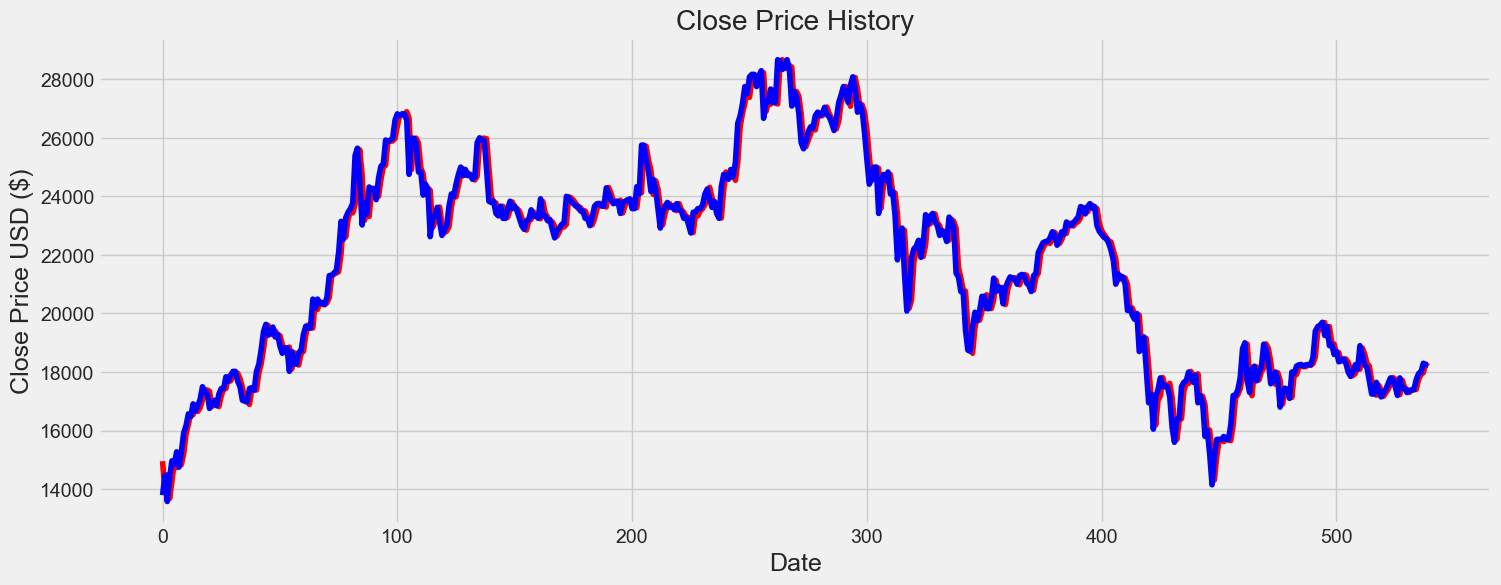

In [278]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df_predictions['Close_predict'], color='red', label='Predicted Close Price')
plt.plot(df_test['Close_test'], color='blue', label='Actual Close Price')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

## 8. [Prediction](#8-bullet)

In [279]:
last_60_days = np.array([y_test[i] for i in range(-1, -61, -1)]) # dự đoán giá của 60 ngày cuối cùng trong dataset
next_days = []  
for i in range(60):
    input_data = x_test[i-60].reshape(-1,60)
    predicted_price = best_lasso.predict(input_data)
    next_days.append(predicted_price)


print("Predicted prices for the next days:")
next_days_array = np.array(next_days).reshape(-1, 1)
dummy_column = np.zeros_like(next_days_array)
next_days_two_columns = np.hstack((next_days_array, dummy_column))
next_days_inversed = scaler.inverse_transform(next_days_two_columns)
final_predictions = next_days_inversed[:, 0]

for i, price in enumerate(final_predictions):
    print(f"Day {i+1}: {price}")
    


Predicted prices for the next days:
Day 1: 17423.907003298358
Day 2: 17130.84716756729
Day 3: 17904.4734182768
Day 4: 17915.563091417032
Day 5: 18161.192032206043
Day 6: 18261.915360699742
Day 7: 18181.36643587148
Day 8: 18186.686199769567
Day 9: 18263.330121029918
Day 10: 18224.846700823764
Day 11: 18287.680580101987
Day 12: 18509.872312073025
Day 13: 19356.936824441484
Day 14: 19515.914971288494
Day 15: 19574.52991384069
Day 16: 19690.382026663807
Day 17: 19215.770266472395
Day 18: 19555.46946920832
Day 19: 19005.932138106586
Day 20: 18956.522112799044
Day 21: 18653.31220025146
Day 22: 18662.864270756578
Day 23: 18370.951234907297
Day 24: 18388.236990018762
Day 25: 18448.01560195971
Day 26: 18339.769241496375
Day 27: 18050.9702843833
Day 28: 17877.364310257843
Day 29: 17950.8569277015
Day 30: 18205.339532553015
Day 31: 18098.676939260367
Day 32: 18825.579456082356
Day 33: 18627.54450208596
Day 34: 18297.394849078268
Day 35: 18202.80518343279
Day 36: 17702.587236944357
Day 37: 17286.7

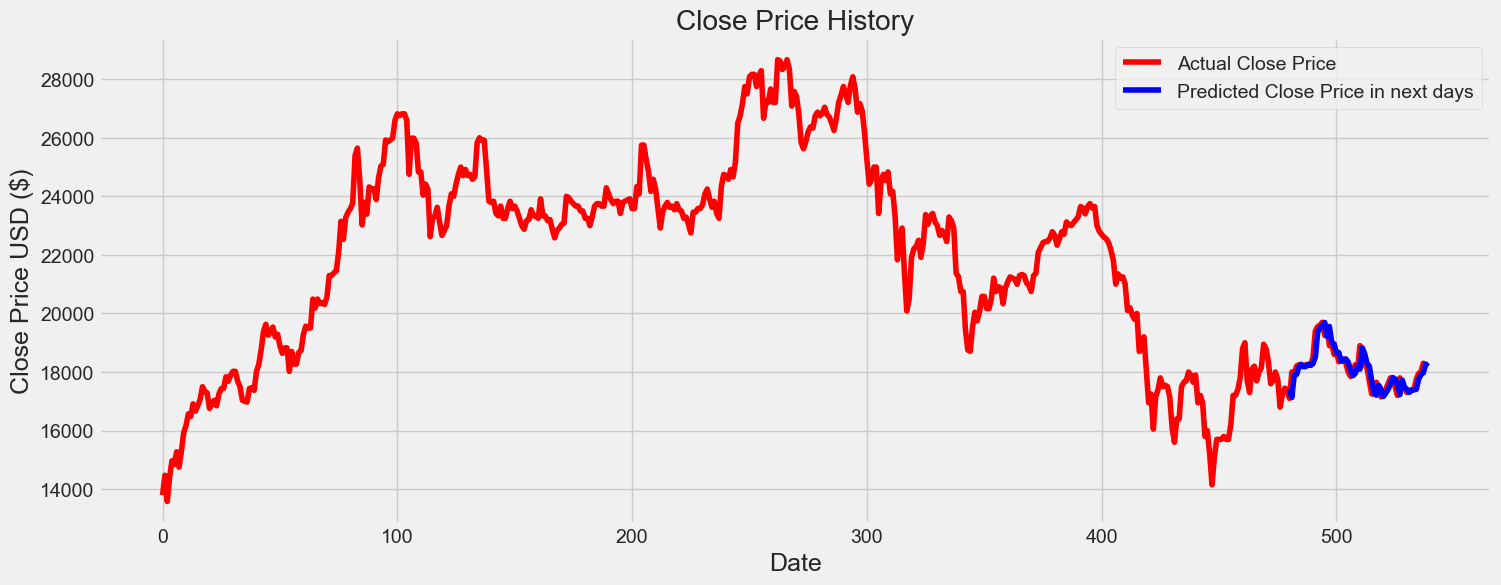

In [280]:
plt.figure(figsize=(16, 6))
plt.title('Close Price History')
plt.plot(y_test[:], color='red', label='Actual Close Price')
plt.plot(range(len(y_test)-60, len(y_test)), final_predictions, color='blue', label='Predicted Close Price in next days')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend()
plt.show()